In [1]:
import sys
import os
import math

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.optimize import fsolve

from tqdm import tqdm

import concatenate
import plot
import regression as reg
import bootstrap as boot

In [2]:
def readfile(path):
    output = np.loadtxt(f'{path}/analysis/Wloop.dat', skiprows=1)
    columns = [output[:, i] for i in range(output.shape[1])]

    return np.column_stack(columns)

def format(y, d_y, digits=2):
    d_digits = int(math.floor(math.log10(abs(d_y))))
    d_y_rounded = round(d_y, -d_digits + (digits - 1))

    decimal_places = -d_digits + (digits - 1)

    value_rounded = round(y, decimal_places)

    formatted = f"{value_rounded:.{decimal_places}f}({int(d_y_rounded * 10**decimal_places):0{digits}d})"
    print(formatted)

def boot_fit(x, y, d_y, b_y, model, lim_inf, lim_sup, extension=None):
    x_fit, y_fit, d_y_fit, b_y_fit = x[lim_inf:lim_sup], y[lim_inf:lim_sup], d_y[lim_inf:lim_sup], b_y[lim_inf:lim_sup]
    opt, cov = curve_fit(model, x_fit, y_fit, sigma=d_y_fit, absolute_sigma=True)
    
    n_boot = len(b_y[0])

    x_linsp = np.linspace(x_fit[0], x_fit[-1], 100)
    if extension:
        x_linsp=np.linspace(extension[0], extension[1], extension[2])
        
    y_linsp = model(x_linsp, *opt)
        
    b_opt = []
    ## b_c2r = []
    b_y_linsp = []
    
    for j in range(n_boot):
        y_fit_j = [b_y_fit[i][j] for i in range(len(b_y_fit))]
        
        opt_j, cov_j = curve_fit(model, x_fit, y_fit_j, sigma=d_y_fit, absolute_sigma=True)
        b_opt.append(opt_j)

        ## b_c2r.append(reg.chi2_corr(x_fit, y_fit_j, model, np.diag(np.array(d_y_fit)**2), *opt_j))
        
        y_linsp_j = model(x_linsp, *opt_j)
        b_y_linsp.append(y_linsp_j)

    d_opt = np.std(b_opt, axis=0, ddof=1)
    
    c2r = reg.chi2_corr(x_fit, y_fit, model, np.diag(np.array(d_y_fit)**2), *opt)
    ## d_c2r = np.std(b_c2r)
    
    d_y_linsp = np.std(b_y_linsp, axis=0, ddof=1)
    return x_linsp, y_linsp, d_y_linsp, opt, d_opt, b_opt, c2r   

## Compute thermalization and insert relevant simulation parameters

lattice parameters: $N_t\times N_s^{2}$, $\frac{2}{g^{2}}=\beta$ (check 2)

Wilson loop parameters: $W(w_t, w_s)$ rectangular

In [3]:
def thermalization(path, wt_max, ws_max):
    '''
    Thermalization of MCMC time-series.
    '''
    os.makedirs(f'{path}/analysis/therm/', exist_ok=True)
    
    output = np.loadtxt(f'{path}/analysis/Wloop.dat', skiprows=1)
                  
    for ws in tqdm(range(0, ws_max, ws_max // 2), desc='ws loop'):
        for wt in range(0, wt_max, wt_max//2):
            Wloop_wt_ws = output[:, wt + wt_max*ws]
    
            x = np.arange(0,len(Wloop_wt_ws), len(Wloop_wt_ws)//500)
            y = Wloop_wt_ws[0:len(Wloop_wt_ws):len(Wloop_wt_ws)//500]

            plt.figure(figsize=(18,12))
            plt.plot(x, y
                    , marker = 'o'
                    , linestyle = '-', linewidth = 0.375
                    , markersize = 2
                    , color = plot.color_dict[1])
            
            plt.xlabel(r'$t_i$')

            plt.grid (True, linestyle = '--', linewidth = 0.25)

            plt.savefig(f'{path}/analysis/therm/therm_wt{wt}_ws{ws}.png', bbox_inches='tight')
            plt.close()

In [29]:
therm_drop = 500
Nt, Ns, beta = 42, 42, 3.75
wt_max, ws_max = 21, 10

input_dir = f'/home/negro/projects/matching/step_scaling/infinite_volume_scheme_PBC/Nt{Nt}_Ns{Ns}_b{beta}'

if not os.path.isdir(f"{input_dir}/analysis/"):
    os.makedirs(f"{input_dir}/analysis/") 
        
if not os.path.isfile(f"{input_dir}/analysis/Wloop.dat"):
    concatenate.concatenate(f"{input_dir}/data", therm_drop, f"{input_dir}/analysis/")

if not os.path.isdir(f"{input_dir}/analysis/therm/"):
    thermalization(input_dir, wt_max, ws_max)

ws loop: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


## Perform block-size analysis for Wilson loops $W(w_t, w_s)$

In [20]:
def bsa_Wilson(path, wt_max, ws_max, *, samples=500, blocksize_min=10, blocksize_max=500, blocksize_step=20):
    ''' 
    Perform block-size analysis of the Wilson loops.
    '''
    os.makedirs(f'{path}/analysis/bsa/', exist_ok=True)
        
    data = readfile(path)
    
    for ws in tqdm(range(0,ws_max, ws_max//2), desc='ws loop'):
        for wt in range(0, wt_max, wt_max//2):
            Wloop = data[:, wt + wt_max*ws]

            block_range, err, d_err = boot.blocksize_analysis_primary(Wloop, samples, [blocksize_min, blocksize_max, blocksize_step])
            
            plt.figure(figsize=(18,12))
            plt.errorbar(block_range, err, yerr=d_err
                        , marker = 'o'
                        , linestyle = '-', linewidth = 0.375
                        , markersize = 2
                        , color = plot.color_dict[1])
            
            plt.xlabel(r'$K$')
            plt.ylabel(r'$\overline{\sigma}_{\overline{F^{(K)}}}$')
            plt.title('Standard error as a function of the blocksize')

            plt.grid(True, which='both', linestyle='--', linewidth=0.25)
        
            plt.savefig(f'{path}/analysis/bsa/blocksize_analysis_wt{wt}_ws{ws}.png', bbox_inches='tight')
            plt.close()
            

In [30]:
bsa_dir = f'{input_dir}/analysis/bsa'

if not os.path.isdir(bsa_dir):
    bsa_Wilson(input_dir, wt_max, ws_max, samples=200, blocksize_min=2, blocksize_step=2, blocksize_max=500)

ws loop: 100%|██████████| 2/2 [00:07<00:00,  3.56s/it]


## get potential $V(w_s)$

$$
V(w_s)=\lim_{w_t\to\infty}-\frac{1}{w_t}\langle W(w_t, w_s)\rangle
$$

In [7]:
def get_potential (path, wt_max, ws_max, *, seed=8220, samples=500, blocksize=200):
    '''
    Compute potential from blocked time-series using bootstrap for error estimation.
    '''
    data = readfile(path)
    
    def id(x):
        return x

    wsplot = np.arange(1,ws_max+1)
    
    blocksizes = [blocksize] * len(wsplot) 
                
    V, d_V, V_bs = [], [], []
    
    for ws, blocksize in tqdm(zip(range(ws_max), blocksizes), desc='ws loop'):
        V_ws, d_V_ws, V_bs_ws = [], [], []
                
        for wt in range(wt_max):
            W = data[:, wt + wt_max*ws]

            args = [id, W]
            
            def potential(x):
                eps=1e-10
                return -np.log(np.clip(x, eps, None))/(wt+1)
            
            _, err, bs = boot.bootstrap_for_secondary(potential, blocksize, samples, 0, args, seed=seed, returnsamples=1)

            V_ws.append(potential(np.mean(W)))
            d_V_ws.append(err)
            V_bs_ws.append(bs)
        
        V.append(V_ws)
        d_V.append(d_V_ws)
        V_bs.append(V_bs_ws)
        
    np.save(f'{path}/analysis/potential_wt', np.array([wsplot, V, d_V, V_bs], dtype=object))

In [31]:
if not os.path.isfile(f"{input_dir}/analysis/potential_wt.npy"):
    get_potential(input_dir, wt_max, ws_max)

ws loop: 10it [00:24,  2.48s/it]


## plot $V(w_t)$ and $V(1/w_t)$

In [9]:
def plot_potential(path, wt_max_plot, ws_max_plot):
    '''
    plot potential both as a function of wt and 1/wt.
    '''
    data = np.load(f'{path}/analysis/potential_wt.npy', allow_pickle=True)
    
    wsplot, res, d_res, res_bs = map(np.array, data[:4])
    
    ## V(w_t)
    plt.figure(figsize=(18,12))
    
    plt.xlabel(r'$w_t$')
    plt.ylabel(r'$aV(w_t)$')

    for i in range(ws_max_plot):
        x_plot = np.arange(1,wt_max_plot[i] + 1)
        effm = res[i]
        d_effm = d_res[i]
        plt.errorbar(x_plot, effm[:wt_max_plot[i]], d_effm[:wt_max_plot[i]], **plot.data(i), label=fr'$w_s={wsplot[i]:.2f}$')
                
    plt.grid (True, linestyle = '--', linewidth = 0.25)
    plt.legend(loc='upper left')
    
    plt.savefig(f"{path}/analysis/effmass.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    ## V(1/w_t)
    plt.figure(figsize = (18,12))
    
    plt.xlabel(r'$1/w_t$')
    plt.ylabel(r'$aV(w_t)$')

    for i in range(ws_max_plot):
        x_plot = np.arange(1,wt_max_plot[i] + 1)
        effm = res[i]
        d_effm = d_res[i]
        plt.errorbar(1/x_plot, effm[:wt_max_plot[i]], d_effm[:wt_max_plot[i]], **plot.data(i), label=fr'$w_s={wsplot[i]:.2f}$')
                
    
    plt.xlim(0,1/(wt_max_plot[0]*0.33))
    plt.ylim(top=effm[-1]*1.1)
    plt.grid (True, linestyle = '--', linewidth = 0.25)
    plt.legend(loc='upper right')
    
    plt.savefig(f"{path}/analysis/pot_ws.png", dpi=300, bbox_inches='tight')
    plt.show()

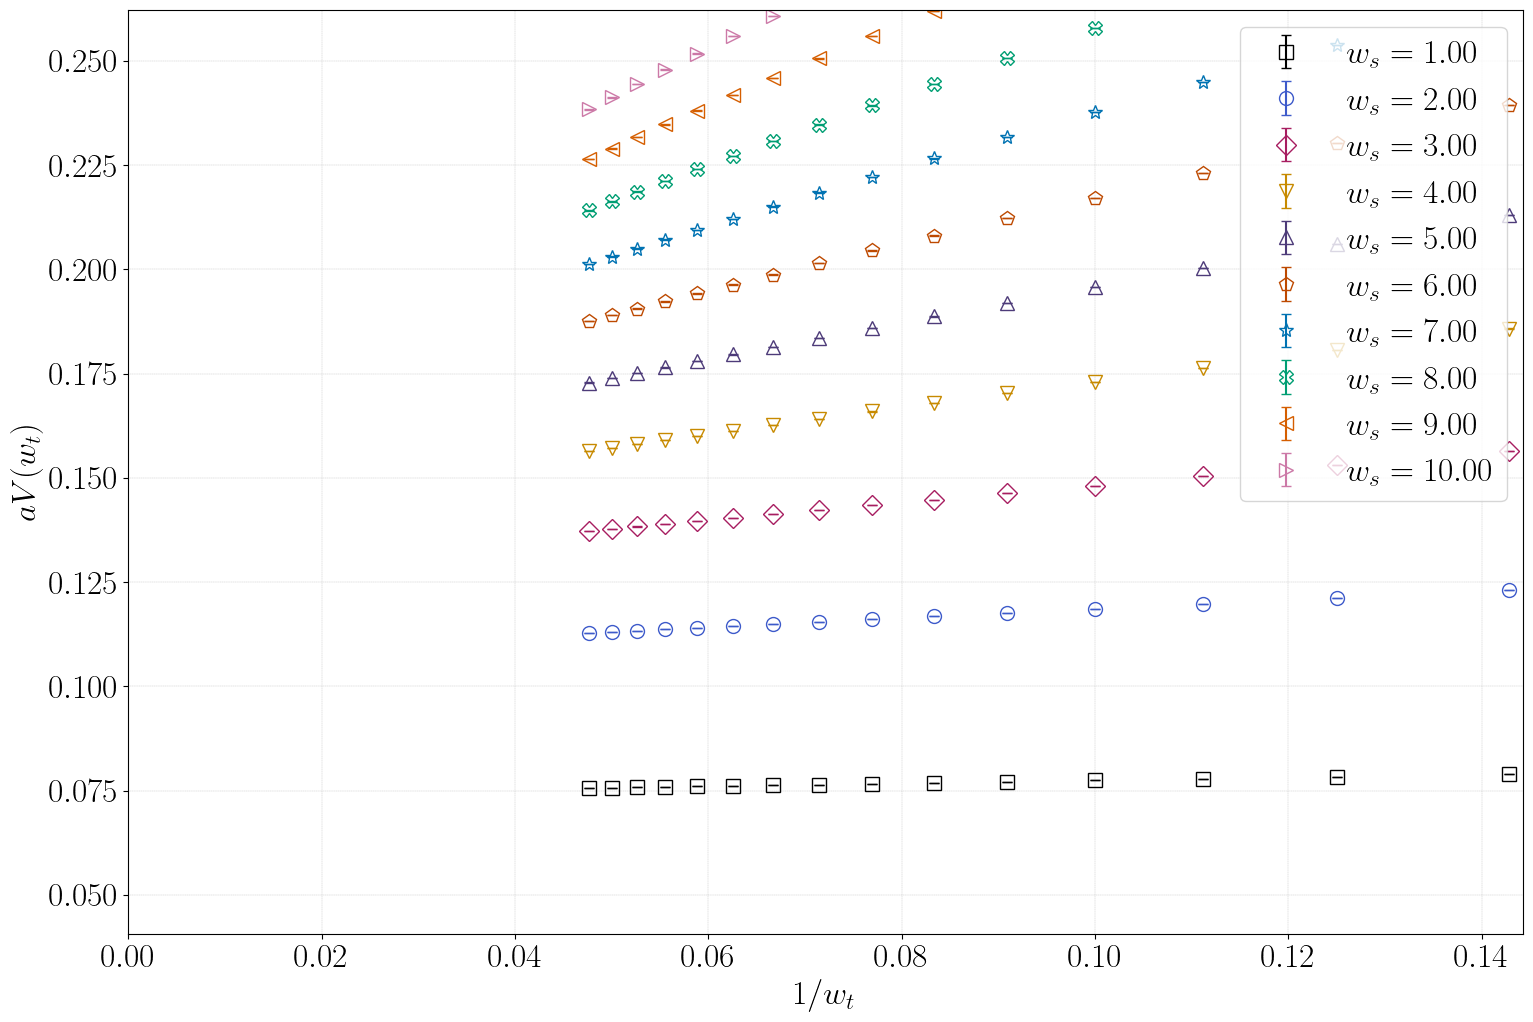

In [32]:
ws_max_plot = 10
wt_max_plot = [wt_max]*ws_max_plot
    
plot_potential(input_dir, wt_max_plot, ws_max_plot)

## Graphically estimate when the result is constant within errors

In [11]:
def find_wtmin(path, ws_max_plot, *, wt_start=2, wt_end=10):
    def model(x, a, b):
        return a + b/x
    
    data = np.load(f'{path}/analysis/potential_wt.npy', allow_pickle=True)
    
    res, d_res, boot_res = map(np.array, data[1:4])
    
    plt.figure(figsize=(18,12))
    
    plt.xlabel(r'$w_{t,min}$')
    plt.ylabel(r'$aV(w_t=\infty)$')
    for i in tqdm(range(ws_max_plot)):
        dp, d_dp = [], []
        for wt_min_fit in range(wt_start,wt_end-3):
            mf, Mf = wt_min_fit, wt_end
            x_fit, y_fit, d_y_fit = np.arange(mf,Mf), np.array(res[i][mf:Mf]), np.array(d_res[i][mf:Mf])
                    
            opt, _ = curve_fit(model, x_fit, y_fit, sigma=d_y_fit, absolute_sigma=True)
            
            boot_y_fit = np.array(boot_res[i][mf:Mf])
            n_boot = np.shape(boot_y_fit)[1]
            
            boot_pot = []

            for j in range(n_boot):
                y_fit = boot_y_fit[:,j]
                
                opt_j, _ = curve_fit(model, x_fit, y_fit, sigma=d_y_fit, absolute_sigma=True)
                
                boot_pot.append(opt_j[0])
            
            pot, d_pot = opt[0], np.std(boot_pot, ddof=1)
            dp.append(pot)
            d_dp.append(d_pot)
            
        if i == 0:
            ylim_inf = dp[-1] * (1-0.2)
        if i == ws_max_plot-1:
            ylim_sup = dp[0] * (1 + 0.2)
         
        plt.errorbar(range(wt_start, wt_end-3), dp, d_dp, **plot.data(i), label=f'$w_s$={i+1}')
    
    plt.ylim(ylim_inf, ylim_sup)
    plt.legend(loc='upper left')
    plt.grid (True, linestyle = '--', linewidth = 0.25)
    plt.savefig(f'{path}/analysis/find_wtmin.png', dpi=300, bbox_inches='tight')
    plt.show()

100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


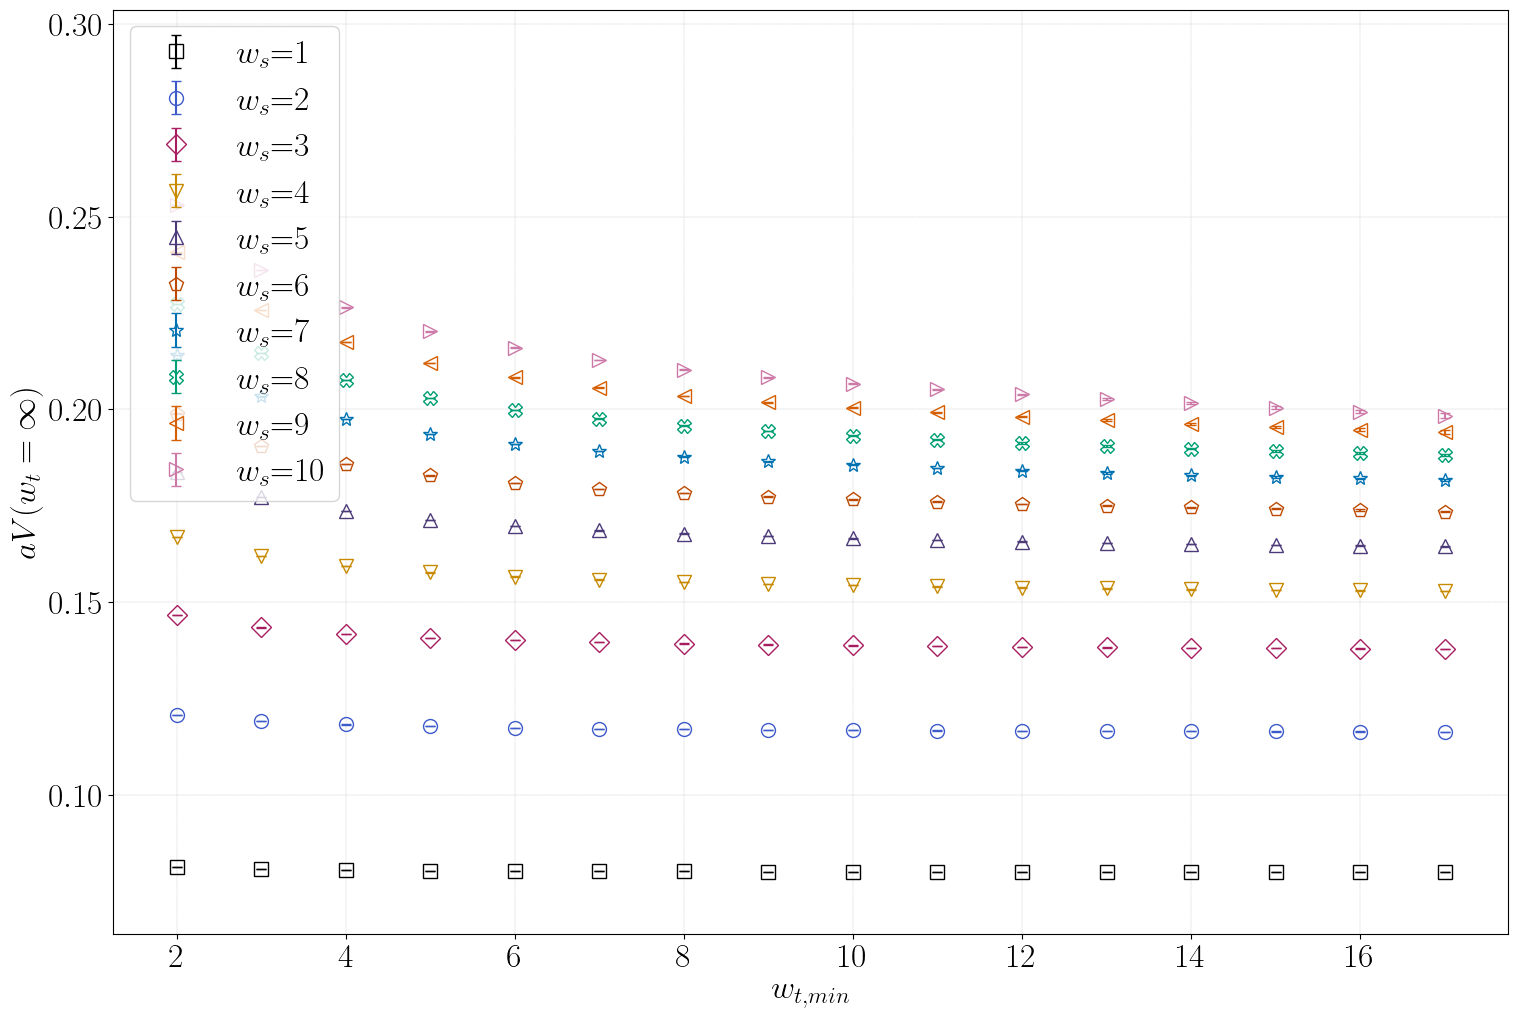

In [24]:
find_wtmin(input_dir, ws_max_plot, wt_start=2, wt_end=21)

## Extrapolate potential for $w_t\to\infty$

In [13]:
def extrap_potential(path, wt_max_plot, ws_max_plot, wt_min_fit, wt_max_fit):
    def model(x, a, b):
        return a + b*x
    
    data = np.load(f"{path}/analysis/potential_wt.npy", allow_pickle=True)
    
    wsplot, res, d_res, boot_res = map(np.array, data[:4])
        
    plt.figure(figsize=(18,12))
    
    plt.xlabel(r'$1/w_t$')
    plt.ylabel(r'$aV(w_t)$')
    
    pot, b_pot = [], []
            
    print("ws pot_n d_pot_n c2r_n")
    for i in range(ws_max_plot):
        Mp = wt_max_plot[i]
        mf, Mf = wt_min_fit[i], wt_max_fit[i]
        x, y, d_y, b_y = 1/np.arange(1,Mp+1), np.array(res[i][0:Mp]), np.array(d_res[i][0:Mp]), np.array(boot_res[i][0:Mp])

        if i == 0:
            ylim_inf = y[-1]*0.5
        if i==ws_max_plot-1:
            ylim_sup = y[0]*0.8
        
        x_linsp, y_linsp, d_y_linsp, opt, d_opt, b_opt, c2r = boot_fit(x, y, d_y, b_y, model, mf, Mf, [0, 1/mf, 51])
        
        pot.append(opt[0])
        b_pot.append([b_opt[j][0] for j in range(len(b_opt))])
        
        plt.errorbar(x, y, d_y, **plot.data(i), label=fr"$w_s={wsplot[i]:.2g}$, $\chi^2_r$={c2r:.2g}, $w_{{t,min}}$={mf}, $w_{{t,max}}$={Mf}")
        
        plt.plot(x_linsp, y_linsp, **plot.fit(i))
        plt.fill_between(x_linsp, y_linsp-d_y_linsp, y_linsp+d_y_linsp, **plot.conf_band(i))

        print(f"{wsplot[i]:.2g} {opt[0]:.6g} {d_opt[0]:.2g} {c2r:.4g}")
        
    plt.xlim(0,1/(wt_max_plot[0]*0.33))
    plt.ylim(ylim_inf,ylim_sup)
    plt.grid (True, linestyle = '--', linewidth = 0.25)
    plt.legend(loc='upper left', fontsize=18)
    plt.savefig(f"{path}/analysis/extrap_pot.png", dpi=300, bbox_inches='tight')
    plt.show()

    wsplot = wsplot[:ws_max_plot].copy()
    save = np.array([wsplot, pot, b_pot], dtype=object)
    np.save(f"{path}/analysis/opt", save)    

ws pot_n d_pot_n c2r_n
1 0.0738486 1.4e-05 0.01683
2 0.10733 2.9e-05 0.1048
3 0.127046 4.8e-05 0.1224
4 0.140809 7.3e-05 0.1471
5 0.151153 9.3e-05 0.3548
6 0.15942 0.00012 0.7953
7 0.166421 0.00016 1.285
8 0.172251 0.00022 1.686
9 0.177267 0.00026 0.7609
10 0.181687 0.00035 1.56


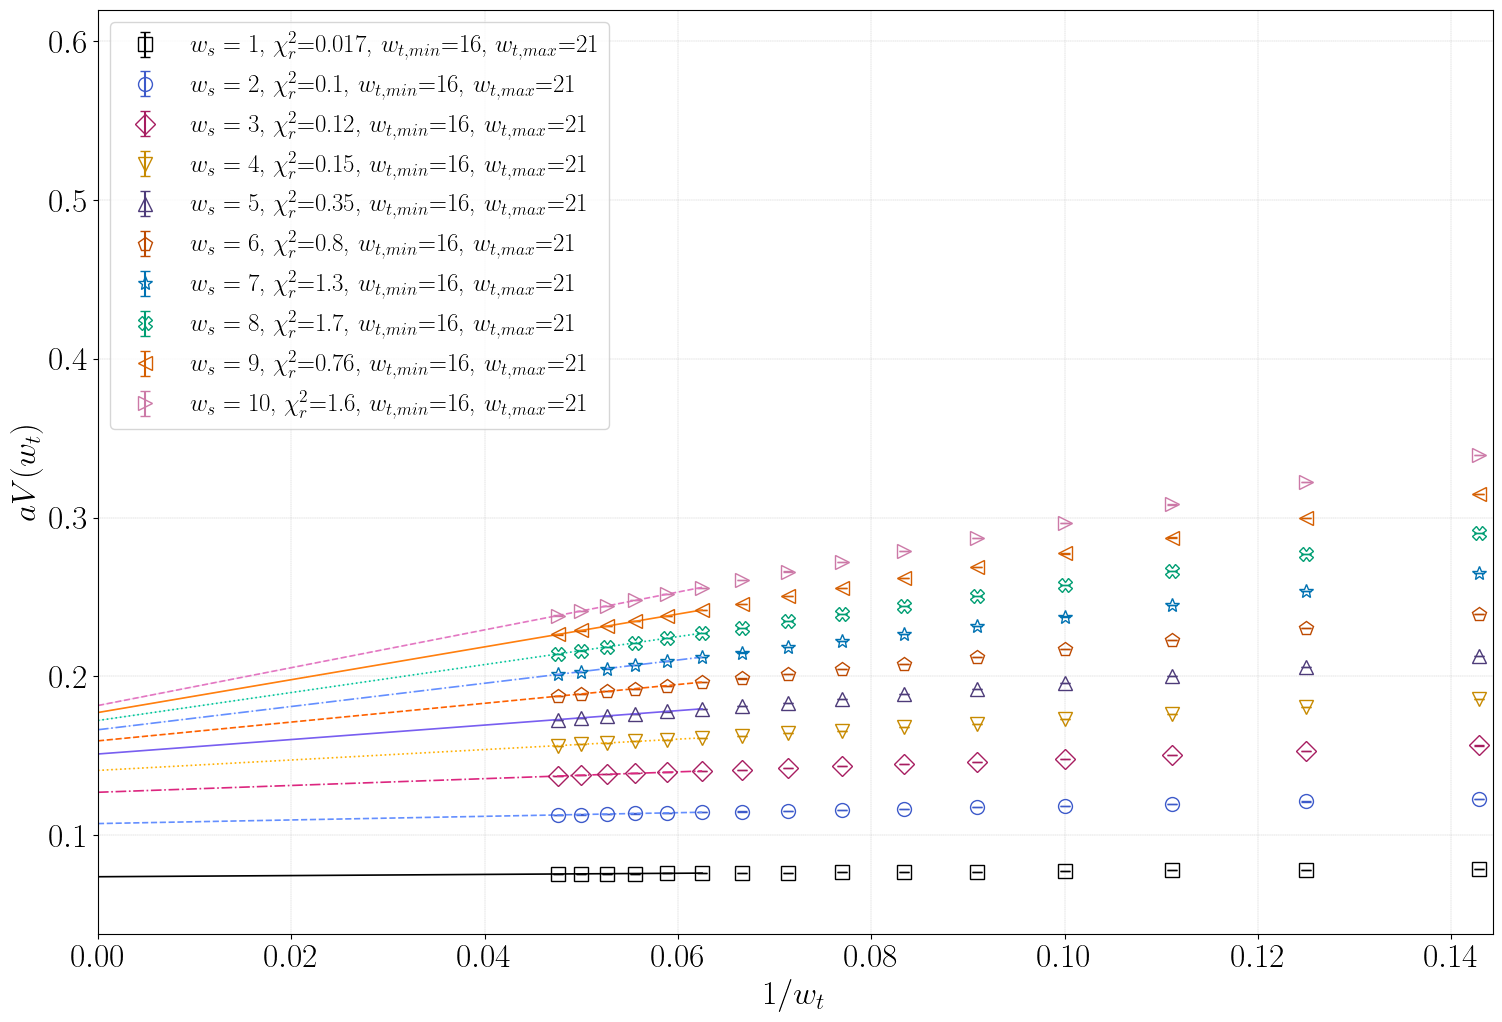

In [33]:
wt_min_fit = [16] * ws_max_plot
wt_max_fit = [21] * ws_max_plot

extrap_potential(input_dir, wt_max_plot, ws_max_plot, wt_min_fit, wt_max_fit)

## Functional form to be fitted for (2+1)D $U(1)$ pure gauge

$$
V(w_s) = a + \sigma w_s + c \log(w_s)
$$

## Then computing the running coupling  with forward finite differences

$$
\overline{g}^{2}(r_i)=r_i^{2}F(r_i, g)=r_i^{2}\frac{V(r_{i+1},g) - V(r_{i}, g)}{r_{i+1}-r_i}
$$


In [15]:
def potential(x, a, b, c):
    return a + b*x + c*np.log(x)

In [16]:
def plotfit_potential(path, *, fit=False, print_res=True, ri=np.array([1, 5, 8])**0.5, start=0, end=10):   
    x, y, b_y = np.load(f"{path}/analysis/opt.npy", allow_pickle=True)
    
    d_y = [np.std(b_y[i], ddof=1) for i in range(len(b_y))]  

    plt.figure(figsize=(18,12))
    plt.errorbar(x, y, d_y, **plot.data(0))
    plt.xlabel(r'r/a')
    plt.ylabel(r'aV(r/a)')
    
    if (fit):
        x_linsp, y_linsp, d_y_linsp, opt, d_opt, b_opt, c2r = boot_fit(x, y, d_y, b_y, potential, start, end)
           
        plt.plot(x_linsp, y_linsp, **plot.fit(4))
        plt.fill_between(x_linsp, y_linsp-d_y_linsp, y_linsp+d_y_linsp, **plot.conf_band(4))

        if (print_res):
            print("opt")
            print(opt)
            print("d_opt")
            print(d_opt)
            print("c2r")
            
    plt.axvline(ri[0])
    plt.axvline(ri[1])
    plt.axvline(ri[2])

    plt.title(f'c2r = {c2r:.4f}\n opt = {opt}\n d_opt = {d_opt}')
    plt.grid (True, linestyle = '--', linewidth = 0.25)
    plt.savefig(f"{path}/analysis/potential_{int(ri[0]**2)}_{int(ri[1]**2)}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    np.save(f"{path}/analysis/opt_potential", np.array([opt, b_opt], dtype=object))

In [17]:
def compute_r2F(path, *, ri=np.array([1, 5, 8])**0.5):
    tmp = np.load(f"{path}/analysis/opt_potential.npy", allow_pickle=True)
    opt, b_opt = tmp[0], tmp[1]

    r1, r2, r3 = map(np.float64, ri)
    
    y_r1, y_r2, y_r3 = potential(r1, *opt), potential(r2, *opt), potential(r3, *opt)

    b_r2F_r1, b_r2F_r2 = [], []
    
    for opt_j in b_opt:
        b_r2F_r1.append(r1**2*(potential(r2, *opt_j)-potential(r1, *opt_j))/(r2-r1))
        b_r2F_r2.append(r2**2*(potential(r3, *opt_j)-potential(r2, *opt_j))/(r3-r2))
    
    r2F_r1 = r1**2*(y_r2-y_r1)/(r2-r1)
    d_r2F_r1 = np.std(b_r2F_r1, ddof=1)
    r2F_r2 = r2**2*(y_r3-y_r2)/(r3-r2)
    d_r2F_r2 = np.std(b_r2F_r2, ddof=1)
    
    print('r2F_r1(d_r2F_r1)')
    format(r2F_r1, d_r2F_r1)
    print('r2F_r2(d_r2F_r2)')
    format(r2F_r2, d_r2F_r2)

    r2F = [r2F_r1, r2F_r2]
    b_r2F = [b_r2F_r1, b_r2F_r2]
    
    np.save(f"{path}/analysis/r2F_{int(ri[0]**2)}_{int(ri[1]**2)}", np.array([r2F, b_r2F], dtype=object))

opt
[ 0.07389605 -0.00099055  0.05109256]
d_opt
[6.89541406e-05 7.95222750e-05 2.68351797e-04]
c2r


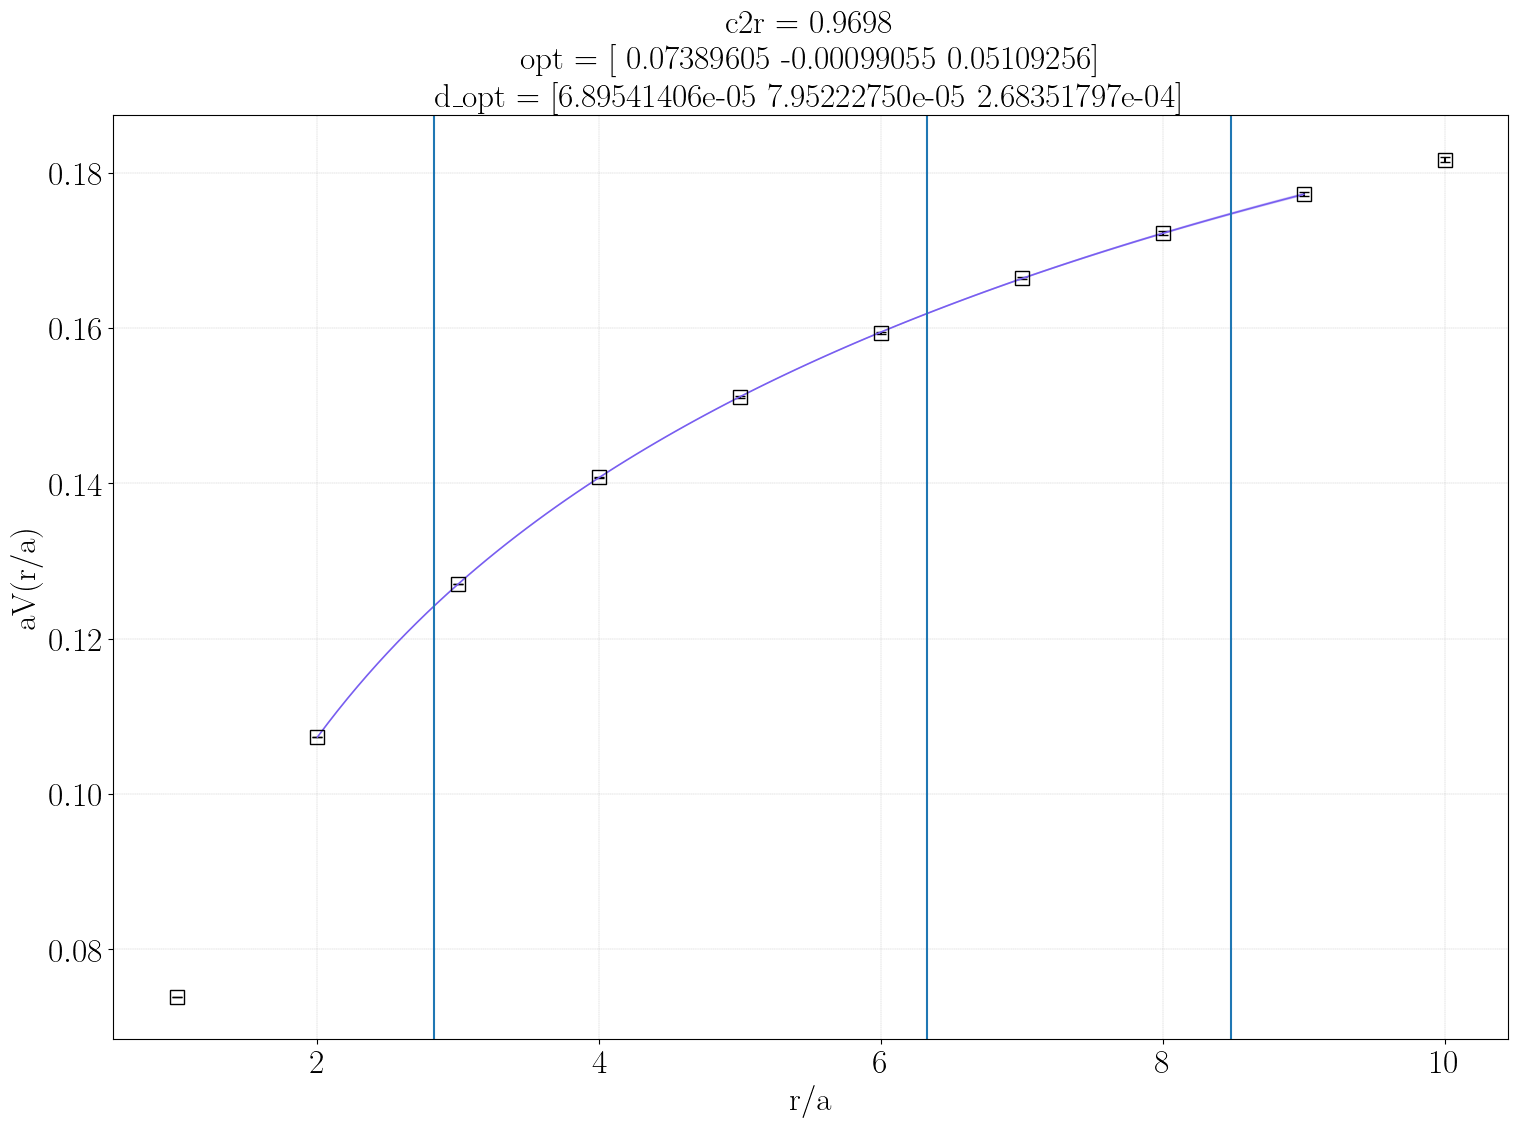

r2F_r1(d_r2F_r1)
0.08616(21)
r2F_r2(d_r2F_r2)
0.2384(18)


In [34]:
rL3 = np.array([1, 5, 8])**0.5
rL4 = np.array([2, 10, 18])**0.5
rL5 = np.array([5, 25, 40])**0.5
rL7 = np.array([8, 40, 72])**0.5
    
rL = [rL7]
        
for rLi in rL:
    plotfit_potential(input_dir, fit=True, ri=rLi, start=1, end=9)
    compute_r2F(input_dir, ri=rLi)